In [7]:
import pandas as pd
import numpy as np
import json
import seaborn as sns


In [8]:
with open('primed_qtable.json', 'r') as file:
    data = json.load(file)

In [9]:
data_df = pd.DataFrame(data)
data_df

,0,1,2,3,4,5,6
0,0.995324,0.635177,0.739714,0.231345,0.560662,0.689378,0.034022
1,0.062668,0.262275,0.898701,0.004443,0.833237,0.173156,0.672679
2,0.583316,0.254341,0.024791,0.772372,0.615744,0.383040,0.243832
3,0.896183,0.767233,0.607778,0.447006,0.974110,0.070123,0.002356
4,0.222478,0.722558,0.096412,0.068648,0.827972,0.800403,0.533006
...,...,...,...,...,...,...,...
5403,0.648837,0.077746,0.937357,0.567402,0.573297,0.373787,0.344666
5404,0.004762,0.869742,0.327629,0.637194,0.063506,0.506430,0.169076
5405,0.308430,0.062666,0.933662,0.367433,0.558472,0.078891,0.010818
5406,0.770342,0.651083,0.578292,0.088198,0.342143,0.913652,0.190099


In [10]:
import pickle

def load_qtable(filename="qtable.pkl"):
    with open(filename, "rb") as f:
        qtable = pickle.load(f)
    return qtable

q_table = load_qtable()

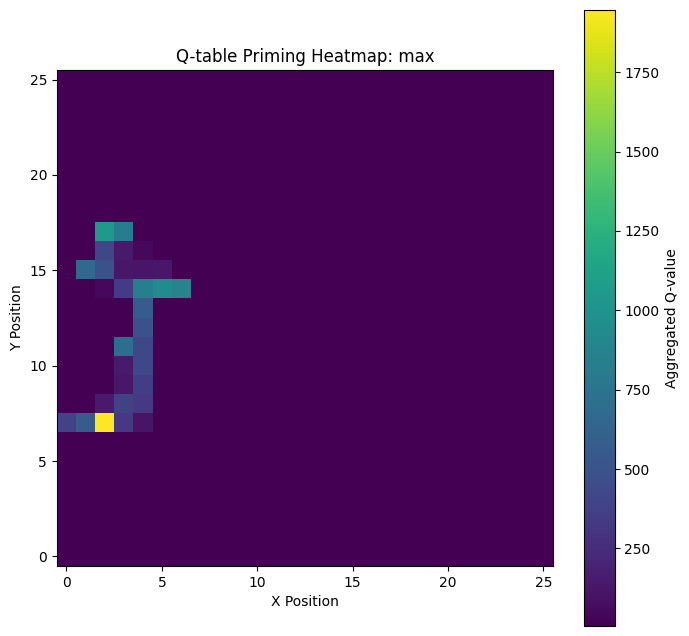

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_qtable_heatmap(qtable, mode="sum"):
    collapsed = np.zeros((26, 26))

    for x in range(26):
        for y in range(26):
            cell_value = 0
            for cart in [0, 1]:
                for items in [0, 1]:
                    for checkout in [0, 1]:
                        idx = ((((x*26 + y)*2 + cart)*2 + items)*2 + checkout)

                        if mode == "sum":
                            cell_value += qtable.loc[idx].sum()
                        elif mode == "max":
                            cell_value += qtable.loc[idx].max()
                        else:
                            raise ValueError("mode wrong")

            collapsed[x, y] = cell_value

    plt.figure(figsize=(8, 8))
    plt.imshow(collapsed.T, origin="lower", aspect="equal")
    plt.colorbar(label="Aggregated Q-value")
    plt.title(f"Q-table Priming Heatmap: {mode}")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.show()

plot_qtable_heatmap(qtable=q_table, mode="max")
